Análise com as seguintes variáveis estudadas:

In [8]:
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Suprimir avisos
warnings.filterwarnings("ignore")

# --- 1) Carregar dados e gerar target ---
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

def resultado_mandante(placar):
    try:
        m, v = map(int, placar.split(" x "))
        return 1 if m > v else 0 if m == v else -1
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

# --- 2) Definir features e target ---
features = [
    "Mandante", "Visitante", "Estádio", "Cidade",
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[features].copy()
y = df["Resultado"]

# --- 3) Label Encoding (evita SettingWithCopyWarning) ---
for col in ["Mandante", "Visitante", "Estádio", "Cidade"]:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])

# --- 4) Configurar validação cruzada intertemporal e métricas ---
tscv = TimeSeriesSplit(n_splits=5)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# --- 5) Definir pipelines com balanceamento via class_weight e regularização ---
models = {
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=100,
            class_weight="balanced",
            max_depth=10,
            min_samples_leaf=5,
            random_state=42
        ))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            C=0.5,
            random_state=42
        ))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            class_weight="balanced",
            probability=True,
            C=1.0,
            kernel="rbf",
            random_state=42
        ))
    ])
}

# --- 6) Rodar cross-validate intertemporal e exibir média±desvio ---
for name, pipe in models.items():
    cv_results = cross_validate(pipe, X, y, cv=tscv, scoring=scoring)
    print(f"\n=== {name} ===")
    print("Cross-validation (mean ± std):")
    for metric in scoring:
        mean = cv_results[f"test_{metric}"].mean()
        std  = cv_results[f"test_{metric}"].std()
        print(f"  {metric:10s}: {mean:.4f} ± {std:.4f}")

# --- 7) Treinar Random Forest final e exibir importância de features ---
rf_pipeline = models["Random Forest"]
rf_pipeline.fit(X, y)
importances = rf_pipeline.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print("\nFeature Importances (Random Forest):")
print(feat_imp.to_string(index=False))



=== Random Forest ===
Cross-validation (mean ± std):
  accuracy  : 0.4134 ± 0.0309
  f1_macro  : 0.3689 ± 0.0332
  roc_auc_ovr: 0.5694 ± 0.0320

=== Logistic Regression ===
Cross-validation (mean ± std):
  accuracy  : 0.3984 ± 0.0341
  f1_macro  : 0.3686 ± 0.0306
  roc_auc_ovr: 0.5540 ± 0.0256

=== SVC ===
Cross-validation (mean ± std):
  accuracy  : 0.3992 ± 0.0413
  f1_macro  : 0.3759 ± 0.0439
  roc_auc_ovr: 0.5240 ± 0.0546

Feature Importances (Random Forest):
              Feature  Importance
     Mandante_Posicao    0.109480
    Visitante_Posicao    0.107254
            Visitante    0.102563
    Mandante_3j_Saldo    0.073207
   Visitante_3j_Saldo    0.071415
             Mandante    0.063066
Visitante_3j_Sofridos    0.061530
Visitante_3j_Marcados    0.060316
 Mandante_3j_Sofridos    0.059779
              Estádio    0.058409
 Mandante_3j_Marcados    0.054942
               Cidade    0.052154
     Temperatura (°C)    0.043806
          Umidade (%)    0.042514
         Vento (km/h)

In [10]:
import pandas as pd
import numpy as np
import warnings
import joblib

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Suprimir avisos
warnings.filterwarnings("ignore")

# --- 1) Carregar dados e gerar target ---
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

def resultado_mandante(placar):
    try:
        m, v = map(int, placar.split(" x "))
        return 1 if m > v else 0 if m == v else -1
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

# --- 2) Definir features e target ---
features = [
    "Mandante", "Visitante", "Estádio", "Cidade",
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[features].copy()
y = df["Resultado"]

# --- 3) Label Encoding (evita SettingWithCopyWarning) ---
for col in ["Mandante", "Visitante", "Estádio", "Cidade"]:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])

# --- 4) Configurar validação cruzada intertemporal e métricas ---
tscv = TimeSeriesSplit(n_splits=5)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# --- 5) Definir pipelines com balanceamento e regularização ---
models = {
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=100,
            class_weight="balanced",
            max_depth=10,
            min_samples_leaf=5,
            random_state=42
        ))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            C=0.5,
            random_state=42
        ))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            class_weight="balanced",
            probability=True,
            C=1.0,
            kernel="rbf",
            random_state=42
        ))
    ])
}

# --- 6) Rodar cross-validate intertemporal e escolher melhor modelo ---
mean_f1_scores = {}

for name, pipe in models.items():
    cv_results = cross_validate(pipe, X, y, cv=tscv, scoring=scoring)
    mean_f1 = cv_results["test_f1_macro"].mean()
    mean_f1_scores[name] = mean_f1

    print(f"\n=== {name} ===")
    print("Cross-validation (mean ± std):")
    for metric in scoring:
        scores = cv_results[f"test_{metric}"]
        print(f"  {metric:10s}: {scores.mean():.4f} ± {scores.std():.4f}")

# identifica o melhor pipeline pelo maior f1_macro
best_name = max(mean_f1_scores, key=mean_f1_scores.get)
best_pipeline = models[best_name]
print(f"\n*** Melhor modelo: {best_name} (mean f1_macro = {mean_f1_scores[best_name]:.4f}) ***")

# --- 7) Treinar o melhor modelo em todo o conjunto e salvar em disk ---
best_pipeline.fit(X, y)
joblib.dump(best_pipeline, "best_model.pkl")
print("Objeto best_model.pkl gravado com sucesso.")



=== Random Forest ===
Cross-validation (mean ± std):
  accuracy  : 0.4134 ± 0.0309
  f1_macro  : 0.3689 ± 0.0332
  roc_auc_ovr: 0.5694 ± 0.0320

=== Logistic Regression ===
Cross-validation (mean ± std):
  accuracy  : 0.3984 ± 0.0341
  f1_macro  : 0.3686 ± 0.0306
  roc_auc_ovr: 0.5540 ± 0.0256

=== SVC ===
Cross-validation (mean ± std):
  accuracy  : 0.3992 ± 0.0413
  f1_macro  : 0.3759 ± 0.0439
  roc_auc_ovr: 0.5240 ± 0.0546

*** Melhor modelo: SVC (mean f1_macro = 0.3759) ***
Objeto best_model.pkl gravado com sucesso.


In [3]:
import pandas as pd
import numpy as np
import warnings
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Suprimir warnings
warnings.filterwarnings("ignore")

# Carregar dataset
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

def resultado_mandante(placar):
    try:
        gols_m, gols_v = map(int, placar.split(" x "))
        return 1 if gols_m > gols_v else 0 if gols_m == gols_v else -1
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

# Features e target
features = [
    "Mandante", "Visitante", "Estádio", "Cidade",
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[features].copy()
y = df["Resultado"]

# Label Encoding
cat_cols = ["Mandante", "Visitante", "Estádio", "Cidade"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])
    encoders[col] = le

# Normalização
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
scaler = StandardScaler()
X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])

# Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Modelos
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(random_state=42)
}

# Avaliação
resultados = {}
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred).tolist()
    resultados[nome] = {
        "Relatório de Classificação": report,
        "Matriz de Confusão": cm
    }

# Exibir acurácia limpa
for nome in resultados:
    acc = resultados[nome]["Relatório de Classificação"]["accuracy"]
    print(f"{nome} - Acurácia: {acc:.4f}")

# Exibir resultado completo em JSON legível
print(json.dumps(resultados, indent=2, ensure_ascii=False))


Random Forest - Acurácia: 0.4496
Logistic Regression - Acurácia: 0.4430
SVC - Acurácia: 0.4254
{
  "Random Forest": {
    "Relatório de Classificação": {
      "-1": {
        "precision": 0.42857142857142855,
        "recall": 0.24812030075187969,
        "f1-score": 0.3142857142857142,
        "support": 133.0
      },
      "0": {
        "precision": 0.32857142857142857,
        "recall": 0.17829457364341086,
        "f1-score": 0.23115577889447234,
        "support": 129.0
      },
      "1": {
        "precision": 0.48220064724919093,
        "recall": 0.7680412371134021,
        "f1-score": 0.5924453280318092,
        "support": 194.0
      },
      "accuracy": 0.44956140350877194,
      "macro avg": {
        "precision": 0.413114501464016,
        "recall": 0.3981520371695642,
        "f1-score": 0.37929560707066523,
        "support": 456.0
      },
      "weighted avg": {
        "precision": 0.4230978944124064,
        "recall": 0.44956140350877194,
        "f1-score": 0.40

Análise mais complexa

In [7]:
import pandas as pd
import numpy as np
import warnings
import json

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Suprimir avisos
warnings.filterwarnings("ignore")

# --- 1) Carregar e preparar os dados ---
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

def resultado_mandante(placar):
    """Retorna 1 se o mandante ganhou, 0 empate, -1 se perdeu."""
    try:
        gols_m, gols_v = map(int, placar.split(" x "))
        return 1 if gols_m > gols_v else 0 if gols_m == gols_v else -1
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

features = [
    "Mandante", "Visitante", "Estádio", "Cidade",
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[features].copy()
y = df["Resultado"]

# --- 2) Label Encoding das variáveis categóricas ---
cat_cols = ["Mandante", "Visitante", "Estádio", "Cidade"]
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# --- 3) Normalização das variáveis numéricas ---
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# --- 4) Configurar validação cruzada intertemporal e métricas ---
tscv = TimeSeriesSplit(n_splits=5)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# --- 5) Definir modelos (RF e LR já têm predict_proba; SVC precisa de probability=True) ---
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(random_state=42, probability=True)
}

# --- 6) Executar cross-validate e métricas finais ---
for nome, modelo in modelos.items():
    print(f"\n=== {nome} ===")
    # 6.1) Validação cruzada intertemporal
    cv_results = cross_validate(modelo, X, y, cv=tscv, scoring=scoring)
    print("Cross-validation (mean ± std):")
    print(f"  Accuracy : {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"  F1 Macro : {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")
    print(f"  ROC AUC  : {cv_results['test_roc_auc_ovr'].mean():.4f} ± {cv_results['test_roc_auc_ovr'].std():.4f}")

    # 6.2) Treino final em todo o conjunto e avaliação
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)

    report = classification_report(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, y_prob, multi_class='ovr')
    cm = confusion_matrix(y, y_pred)

    print("\nClassification Report:")
    print(report)
    print(f"ROC AUC (OvR): {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)



=== Random Forest ===
Cross-validation (mean ± std):
  Accuracy : 0.4158 ± 0.0302
  F1 Macro : 0.3440 ± 0.0335
  ROC AUC  : 0.5566 ± 0.0268

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       400
           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       700

    accuracy                           1.00      1520
   macro avg       1.00      1.00      1.00      1520
weighted avg       1.00      1.00      1.00      1520

ROC AUC (OvR): 1.0000

Confusion Matrix:
[[400   0   0]
 [  0 420   0]
 [  0   0 700]]

=== Logistic Regression ===
Cross-validation (mean ± std):
  Accuracy : 0.4609 ± 0.0283
  F1 Macro : 0.3336 ± 0.0115
  ROC AUC  : 0.5585 ± 0.0247

Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.22      0.29       400
           0       0.32      0.03      0.05       420
           1       0.49      0.88

Plotar

C:\Users\msdof\AppData\Local\Temp\ipykernel_7472\3322460390.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\msdof\AppData\Local\Temp\ipykernel_7472\3322460390.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\msdof\AppData\Local\Temp\ipykernel_7472\3322460390.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Avaliação do Modelo:
{'Relatório de Classificação': {'-1': {'precision': 0.4444444444444444, 'recall': 0.24060150375939848, 'f1-score': 0.3121951219512195, 'support': 133.0}, '0': {'precision': 0.35064935064935066, 'recall': 0.20930232558139536, 'f1-score': 0.2621359223300971, 'support': 129.0}, '1': {'precision': 0.4723127035830619, 'recall': 0.7474226804123711, 'f1-score': 0.5788423153692616, 'support': 194.0}, 'accuracy': 0.4473684210526316, 'macro avg': {'precision': 0.42246883289228565, 'recall': 0.3991088365843883, 'f1-score': 0.384391119883526, 'support': 456.0}, 'weighted avg': {'precision': 0.42976653912278806, 'recall': 0.4473684210526316, 'f1-score': 0.4114756455739725, 'support': 456.0}}, 'Matriz de Confusão': [[32, 22, 79], [19, 27, 83], [21, 28, 145]]}

Importância de cada variável:
                  Feature  Importance
1               Visitante    0.112060
14      Visitante_Posicao    0.106702
10       Mandante_Posicao    0.098238
7       Mandante_3j_Saldo    0.075721
11

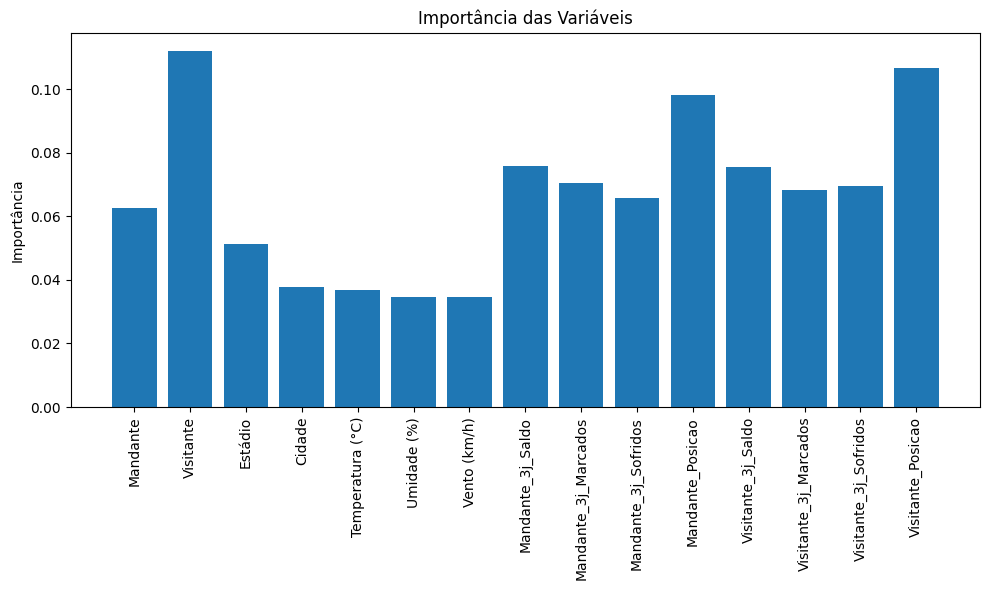

In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Carrega o CSV exportado com os novos indicadores
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

# Criação da variável alvo com base no placar 
def resultado_mandante(placar):
    try:
        gols_m, gols_v = map(int, placar.split(" x "))
        if gols_m > gols_v:
            return 1  # Vitória do mandante
        elif gols_m == gols_v:
            return 0  # Empate
        else:
            return -1  # Derrota do mandante
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

# Seleção de features:
features = [
    "Mandante", "Visitante", "Estádio", "Cidade",
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[features]
y = df["Resultado"]

# Tratamento das variáveis categóricas
cat_cols = ["Mandante", "Visitante", "Estádio", "Cidade"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

# Padronização das variáveis numéricas
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Separação dos dados em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Treinamento do modelo RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=100)
model.fit(X_train, y_train)

# Predição e avaliação do modelo
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

resultado = {
    "Relatório de Classificação": report,
    "Matriz de Confusão": cm.tolist()
}

print("Avaliação do Modelo:")
print(resultado)

# ======================================================================
# Cálculo da importância de cada variável (feature importances)
# ======================================================================
importances = model.feature_importances_
features_list = X.columns

# Cria um DataFrame para visualizar as importâncias de forma organizada
feature_importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nImportância de cada variável:")
print(feature_importance_df)

# Visualização gráfica das importâncias
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis")
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), features_list, rotation=90)
plt.ylabel("Importância")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np

# pré-requisitos:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 1) Carregando dados e criando target
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

# Criação da variável alvo com base no placar 
def resultado_mandante(placar):
    try:
        gols_m, gols_v = map(int, placar.split(" x "))
        if gols_m > gols_v:
            return 1  # Vitória do mandante
        elif gols_m == gols_v:
            return 0  # Empate
        else:
            return -1  # Derrota do mandante
    except:
        return np.nan

df["Resultado"] = df["Placar"].apply(resultado_mandante)
df.dropna(subset=["Resultado"], inplace=True)

# 2) Definindo features
cat_cols = ["Mandante", "Visitante", "Estádio", "Cidade"]
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]
X = df[cat_cols + num_cols]
y = df["Resultado"]

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 4) Pré-processamento
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ("scale", StandardScaler(), num_cols),
])

# 5) Pipeline com SMOTE + XGBoost
pipeline = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )),
])

# 6) Espaço de busca de hiper-parâmetros
param_dist = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.6, 0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=20, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1, random_state=42
)

# 7) Treino e busca de melhores parâmetros
search.fit(X_train, y_train)

print("Melhores parâmetros:\n", search.best_params_)

# 8) Avaliação no conjunto de teste
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)

print("\nAcurácia:", accuracy_score(y_test, y_pred))
print("F1-Macro:", f1_score(y_test, y_pred, average="macro"))
print("ROC AUC (ovo):", roc_auc_score(
    pd.get_dummies(y_test), y_proba, average="macro", multi_class="ovr"
))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# 9) Importância das features
clf = search.best_estimator_.named_steps["clf"]
ohe = search.best_estimator_.named_steps["prep"].named_transformers_["ohe"]
feat_ohe = ohe.get_feature_names_out(cat_cols)
feat_names = np.concatenate([feat_ohe, num_cols])

importances = clf.feature_importances_
imp_df = (
    pd.DataFrame({"Feature": feat_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
)
print("\nImportâncias:\n", imp_df)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]


In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier

# 1) Carrega CSV e cria a variável alvo original
df = pd.read_csv("brasileiro_variaveis_historicas.csv")

def resultado_mandante(placar):
    m, v = map(int, placar.split(" x "))
    return 1 if m > v else 0 if m == v else -1

df["Resultado"] = df["Placar"].apply(resultado_mandante).dropna()

# 2) Mapeia {-1,0,1} → {0,1,2} para ser compatível com XGBClassifier
df["Resultado_Num"] = df["Resultado"].map({-1: 0, 0: 1, 1: 2})

# 3) Seleciona features e target final
cat_cols = ["Mandante", "Visitante"]
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao"
]

X = df[cat_cols + num_cols]
y = df["Resultado_Num"]

# 4) Split estratificado em treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 5) Oversampling manual das classes minoritárias em X_train
train_df = pd.concat([X_train, y_train.rename("Resultado_Num")], axis=1)
groups = [train_df[train_df.Resultado_Num == cls] for cls in train_df.Resultado_Num.unique()]
n_max = max(g.shape[0] for g in groups)

upsampled = [g.sample(n_max, replace=True, random_state=42) for g in groups]
train_up = pd.concat(upsampled).sample(frac=1, random_state=42)  # shuffle

X_train_up = train_up[cat_cols + num_cols]
y_train_up = train_up["Resultado_Num"]

# 6) Pré-processamento: OneHot para categorias + StandardScaler para numéricas
preprocessor = ColumnTransformer([
    ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ("scale",  StandardScaler(), num_cols),
])

# 7) Pipeline com XGBoost
pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf",  XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )),
])

# 8) Espaço de busca de hiper-parâmetros
param_dist = {
    "clf__n_estimators":    [100, 200, 500],
    "clf__max_depth":       [3, 5, 7],
    "clf__learning_rate":   [0.01, 0.1, 0.2],
    "clf__subsample":       [0.6, 0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 9) Treina e encontra os melhores parâmetros
search.fit(X_train_up, y_train_up)

print("Melhores parâmetros:", search.best_params_)

# 10) Avaliação no conjunto de teste
y_pred  = search.predict(X_test)
y_proba = search.predict_proba(X_test)

print("\n--- Métricas de Desempenho ---")
print("Acurácia:   ", accuracy_score(y_test, y_pred))
print("F1-Macro:   ", f1_score(y_test, y_pred, average="macro"))
print("ROC AUC ovo:", roc_auc_score(
    pd.get_dummies(y_test), y_proba,
    average="macro", multi_class="ovr"
))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# 11) Importância das features
best_clf = search.best_estimator_.named_steps["clf"]
ohe      = search.best_estimator_.named_steps["prep"].named_transformers_["ohe"]
feat_ohe = ohe.get_feature_names_out(cat_cols)
feat_names = np.concatenate([feat_ohe, num_cols])

importances = best_clf.feature_importances_
imp_df = (
    pd.DataFrame({"Feature": feat_names, "Importance": importances})
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
)

print("\nImportâncias das variáveis:\n", imp_df)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.2}

--- Métricas de Desempenho ---
Acurácia:    0.44298245614035087
F1-Macro:    0.4010446424239527
ROC AUC ovo: 0.562024468210952

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.40      0.37       120
           1       0.28      0.21      0.24       126
           2       0.58      0.60      0.59       210

    accuracy                           0.44       456
   macro avg       0.40      0.41      0.40       456
weighted avg       0.43      0.44      0.44       456

Matriz de Confusão:
 [[ 48  30  42]
 [ 49  27  50]
 [ 44  39 127]]

Importâncias das variáveis:
                                   Feature  Importance
0       Mandante_Esporte Clube Bahia - BA    0.032133
1                 Visitante_Coritiba - PR    0.027288
2            Visitante_Internacional - RS    0.022949
3                Visitante_Juventu

Smote

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    roc_auc_score, confusion_matrix
)

# 1) Carrega dados e target
df = pd.read_csv("brasileiro_variaveis_historicas.csv")
def resultado_mandante(placar):
    m, v = map(int, placar.split(" x "))
    return 1 if m > v else 0 if m == v else -1
df["Resultado_Num"] = df["Placar"].apply(resultado_mandante).map({-1:0, 0:1, 1:2})

# 2) Feature engineering: deltas
df["Delta_Posicao"] = df["Mandante_Posicao"] - df["Visitante_Posicao"]
df["Delta_3j_Saldo"]   = df["Mandante_3j_Saldo"]  - df["Visitante_3j_Saldo"]
df["Delta_3j_Marcados"]= df["Mandante_3j_Marcados"] - df["Visitante_3j_Marcados"]
df["Delta_3j_Sofridos"]= df["Mandante_3j_Sofridos"] - df["Visitante_3j_Sofridos"]

cat_cols = ["Mandante", "Visitante"]
num_cols = [
    "Temperatura (°C)", "Umidade (%)", "Vento (km/h)",
    "Mandante_3j_Saldo", "Mandante_3j_Marcados", "Mandante_3j_Sofridos", "Mandante_Posicao",
    "Visitante_3j_Saldo", "Visitante_3j_Marcados", "Visitante_3j_Sofridos", "Visitante_Posicao",
    "Delta_Posicao", "Delta_3j_Saldo", "Delta_3j_Marcados", "Delta_3j_Sofridos"
]

X = df[cat_cols + num_cols]
y = df["Resultado_Num"]

# 3) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 4) Pré-processamento
preprocessor = ColumnTransformer([
    ("ohe",   OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ("sca",   StandardScaler(), num_cols),
])

# 5) Pipeline com SMOTE + XGBoost
pipeline = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf",   XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )),
])

# 6) Espaço ampliado de hiper-parâmetros
param_dist = {
    "clf__n_estimators":    [100, 200, 500],
    "clf__max_depth":       [3, 5, 7],
    "clf__learning_rate":   [0.01, 0.1, 0.2],
    "clf__subsample":       [0.6, 0.8, 1.0],
    "clf__colsample_bytree":[0.6, 0.8, 1.0],
    "clf__gamma":           [0, 1, 5],
    "clf__min_child_weight":[1, 3, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 7) Treina e busca melhores parâmetros
search.fit(X_train, y_train)
print("Melhores parâmetros:", search.best_params_)

# 8) Avaliação final
y_pred  = search.predict(X_test)
y_proba = search.predict_proba(X_test)

print("\nAcurácia:  ", accuracy_score(y_test, y_pred))
print("F1-Macro:  ", f1_score(y_test, y_pred, average="macro"))
print("ROC AUC:   ", roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class="ovr"))
print("\nReport:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\msdof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__min_child_weight': 3, 'clf__max_depth': 5, 'clf__learning_rate': 0.2, 'clf__gamma': 5, 'clf__colsample_bytree': 1.0}

Acurácia:   0.46271929824561403
F1-Macro:   0.4304925761049194
ROC AUC:    0.5983254193111917

Report:
               precision    recall  f1-score   support

           0       0.36      0.43      0.39       120
           1       0.37      0.28      0.32       126
           2       0.57      0.59      0.58       210

    accuracy                           0.46       456
   macro avg       0.43      0.43      0.43       456
weighted avg       0.46      0.46      0.46       456

Confusion Matrix:
 [[ 52  21  47]
 [ 45  35  46]
 [ 47  39 124]]


In [6]:
joblib.dump(search.best_estimator_, "best_pipeline.pkl")


NameError: name 'joblib' is not defined

In [5]:
import pandas as pd

# Carrega os dados já pré-processados (df é o DataFrame final com 1.520 linhas)
# df = pd.read_csv("brasileiro_variaveis_historicas_limpo.csv")

# Seleção das variáveis para a Tabela 1
vars_para_tabela = [
    "Temperatura (°C)",
    "Umidade (%)",
    "Vento (km/h)",
    "Mandante_3j_Saldo",
    "Delta_Posicao"
]

# Cálculo das estatísticas descritivas e formatação
tabela1 = (
    df[vars_para_tabela]
    .agg(["count", "mean", "std", "min", "max"])
    .rename(index={"count": "N", "std": "DP"})
    .round({"mean": 1, "DP": 1})
)

display(tabela1)


,Temperatura (°C),Umidade (%),Vento (km/h),Mandante_3j_Saldo,Delta_Posicao
N,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000
mean,21.204737,88.138816,4.767895,-0.157895,0.134868
DP,3.401708,6.968268,3.818407,2.717571,8.089011
min,16.100000,74.000000,0.400000,-9.000000,-19.000000
max,27.600000,98.000000,15.100000,11.000000,19.000000
